## 模型选择、欠拟合和过拟合


In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

$y= 5 +1.2x - 3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+\epsilon$

In [11]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [12]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.4908],
         [0.5256]]),
 tensor([[1.0000e+00, 4.9076e-01, 1.2042e-01, 1.9700e-02, 2.4170e-03, 2.3723e-04,
          1.9404e-05, 1.3604e-06, 8.3453e-08, 4.5506e-09, 2.2333e-10, 9.9636e-12,
          4.0748e-13, 1.5383e-14, 5.3923e-16, 1.7642e-17, 5.4113e-19, 1.5622e-20,
          4.2591e-22, 1.1001e-23],
         [1.0000e+00, 5.2564e-01, 1.3815e-01, 2.4205e-02, 3.1808e-03, 3.3439e-04,
          2.9294e-05, 2.1998e-06, 1.4453e-07, 8.4414e-09, 4.4371e-10, 2.1203e-11,
          9.2875e-13, 3.7553e-14, 1.4099e-15, 4.9408e-17, 1.6232e-18, 5.0188e-20,
          1.4656e-21, 4.0546e-23]]),
 tensor([5.4686, 5.2682]))

### 对模型进行训练

In [13]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

### 定义训练函数

In [14]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

##### 正常

weight: [[ 5.0015397  1.2138997 -3.3947365  5.5815945]]


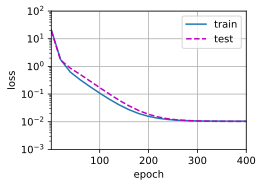

In [15]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

##### 欠拟合

weight: [[3.3366807 3.6579485]]


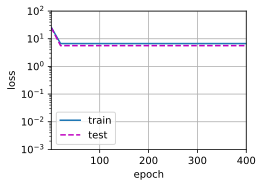

In [16]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

##### 过拟合


weight: [[ 4.9946876   1.3076687  -3.3357728   5.1325164  -0.22000855  1.2838588
   0.1348854   0.18396196 -0.18982705  0.18145734  0.15668002 -0.10579375
   0.21051799  0.06178404  0.20447639  0.06874715 -0.1295295  -0.0428821
   0.18804358  0.17567839]]


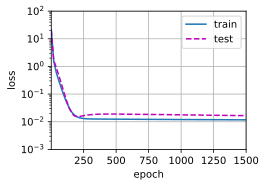

In [17]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)